In [8]:
import pandas as pd
import numpy as np
df = pd.read_csv("../data/raw/transactions.csv")
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [9]:
df['is_income'] = df['type'] == 'CASH_IN'
df['is_expense'] = df['type'].isin(['CASH_OUT', 'PAYMENT', 'DEBIT', 'TRANSFER'])
df['expense_group'] = 'OTHER'
df.loc[df['type'].isin(['CASH_OUT', 'PAYMENT', 'DEBIT']), 'expense_group'] = 'SPEND'
df.loc[df['type'] == 'TRANSFER', 'expense_group'] = 'TRANSFER'
df['month'] = (df['step'] // 30) + 1


In [10]:
df['income_amount'] = np.where(df['is_income'], df['amount'], 0)
df['expense_amount'] = np.where(df['is_expense'], df['amount'], 0)
df['spend_amount_col'] = np.where(df['expense_group'] == 'SPEND', df['amount'], 0)
df['transfer_amount_col'] = np.where(df['expense_group'] == 'TRANSFER', df['amount'], 0)


In [11]:
monthly = df.groupby(['nameOrig', 'month'], as_index=False).agg(
    monthly_income=('income_amount', 'sum'),
    monthly_expense=('expense_amount', 'sum'),
    spend_amount=('spend_amount_col', 'sum'),
    transfer_amount=('transfer_amount_col', 'sum'),
    avg_balance=('newbalanceOrig', 'mean')
)


In [12]:
monthly['savings'] = monthly['monthly_income'] - monthly['monthly_expense']
monthly['savings_rate'] = np.where(
    monthly['monthly_income'] > 0,
    monthly['savings'] / monthly['monthly_income'],
    0
)
monthly['expense_income_ratio'] = np.where(
    monthly['monthly_income'] > 0,
    monthly['monthly_expense'] / monthly['monthly_income'],
    0
)
monthly['transfer_ratio'] = np.where(
    monthly['monthly_expense'] > 0,
    monthly['transfer_amount'] / monthly['monthly_expense'],
    0
)


In [13]:
monthly['zero_income_stress'] = monthly['monthly_income'] == 0
monthly['overspend_stress'] = monthly['expense_income_ratio'] > 1
monthly['low_savings_stress'] = monthly['savings_rate'] < 0.1
monthly['high_transfer_stress'] = monthly['transfer_ratio'] > 0.5


In [14]:
monthly['stress_score'] = (
    3 * monthly['zero_income_stress'].astype(int) +
    2 * monthly['overspend_stress'].astype(int) +
    2 * monthly['low_savings_stress'].astype(int) +
    1 * monthly['high_transfer_stress'].astype(int)
)


In [15]:
def categorize(score):
    if score >= 6:
        return 'Severe Stress'
    elif score >= 3:
        return 'High Stress'
    else:
        return 'Stable'

monthly['stress_category'] = monthly['stress_score'].apply(categorize)


In [16]:
monthly['is_stressed'] = monthly['stress_score'] >= 3
monthly['is_severe'] = monthly['stress_score'] >= 6
customer_summary = monthly.groupby('nameOrig', as_index=False).agg(
    total_months=('month', 'count'),
    stressed_months=('is_stressed', 'sum'),
    severe_months=('is_severe', 'sum')
)


In [17]:
monthly['stress_category'].value_counts(normalize=True) * 100
monthly.groupby('month')['stress_score'].mean()


month
1     4.001730
2     3.989059
3     5.500000
4     4.265942
5     3.950536
6     3.961609
7     3.983603
8     4.008034
9     3.995371
10    3.995522
11    3.972101
12    3.982676
13    3.988446
14    3.984726
15    3.867392
16    3.980393
17    3.963328
18    3.946996
19    3.968336
20    3.966070
21    3.914130
22    3.874494
23    3.906882
24    3.995278
25    5.500000
Name: stress_score, dtype: float64

In [18]:
customer_summary['stress_ratio'] = (
    customer_summary['stressed_months'] /
    customer_summary['total_months']
)
def classify_customer(row):
    if row['severe_months'] >= 2 or row['stress_ratio'] >= 0.5:
        return 'Chronic Stress'
    elif row['stressed_months'] > 0:
        return 'Temporary Stress'
    else:
        return 'Stable'
customer_summary['customer_stress_type'] = (
    customer_summary.apply(classify_customer, axis=1)
)


In [19]:
customer_segment_dist = (
    customer_summary['customer_stress_type']
    .value_counts(normalize=True)
    .mul(100)
    .round(2)
    .reset_index()
)

customer_segment_dist.columns = ['customer_stress_type', 'percentage']



In [20]:
monthly_stress_trend = monthly.groupby('month', as_index=False).agg(
    avg_stress_score=('stress_score', 'mean'),
    stressed_customers=('is_stressed', 'sum')
)
    

In [21]:
stress_drivers = monthly[monthly['is_stressed']].agg({
    'zero_income_stress': 'mean',
    'overspend_stress': 'mean',
    'low_savings_stress': 'mean',
    'high_transfer_stress': 'mean'
}).mul(100).round(2).T.reset_index()

stress_drivers.columns = ['stress_driver', 'percentage']


In [22]:
high_risk_customers = customer_summary[
    customer_summary['customer_stress_type'] == 'Chronic Stress'
].sort_values(
    ['severe_months', 'stressed_months'],
    ascending=False
)


In [23]:
customer_month_view = monthly[[
    'nameOrig',
    'month',
    'monthly_income',
    'monthly_expense',
    'savings',
    'stress_score',
    'stress_category'
]]


In [24]:
from IPython.display import display
display(customer_segment_dist)
display(monthly_stress_trend)
display(stress_drivers)
display(high_risk_customers.head(10))

,customer_stress_type,percentage
0,Chronic Stress,78.03
1,Stable,21.97
2,Temporary Stress,0.00


,month,avg_stress_score,stressed_customers
0,1,4.001730,451849
1,2,3.989059,354553
2,3,5.500000,370
3,4,4.265942,28994
4,5,3.950536,344932
5,6,3.961609,385450
6,7,3.983603,505263
7,8,4.008034,416431
8,9,3.995371,332234
9,10,3.995522,337842


,stress_driver,percentage
0,zero_income_stress,100.00
1,overspend_stress,0.00
2,low_savings_stress,100.00
3,high_transfer_stress,10.74


,nameOrig,total_months,stressed_months,severe_months,stress_ratio,customer_stress_type
6671,C1002027777,2,2,2,1.0,Chronic Stress
97686,C1029713918,2,2,2,1.0,Chronic Stress
532182,C1162384917,2,2,2,1.0,Chronic Stress
607814,C1185263836,2,2,2,1.0,Chronic Stress
628985,C1191696703,2,2,2,1.0,Chronic Stress
696206,C1212164269,2,2,2,1.0,Chronic Stress
846111,C125799853,2,2,2,1.0,Chronic Stress
858396,C1261747802,2,2,2,1.0,Chronic Stress
1028950,C1313642079,2,2,2,1.0,Chronic Stress
1040240,C1317020957,2,2,2,1.0,Chronic Stress


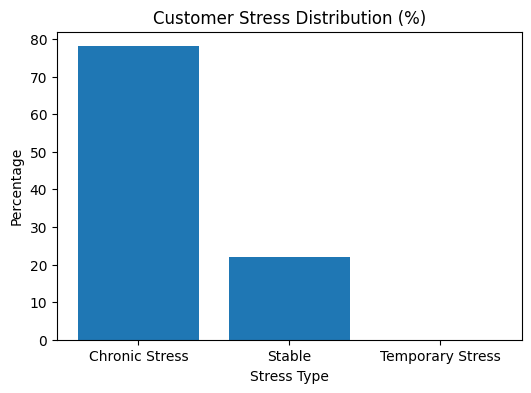

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.bar(
    customer_segment_dist['customer_stress_type'],
    customer_segment_dist['percentage']
)
plt.title('Customer Stress Distribution (%)')
plt.ylabel('Percentage')
plt.xlabel('Stress Type')
plt.show()


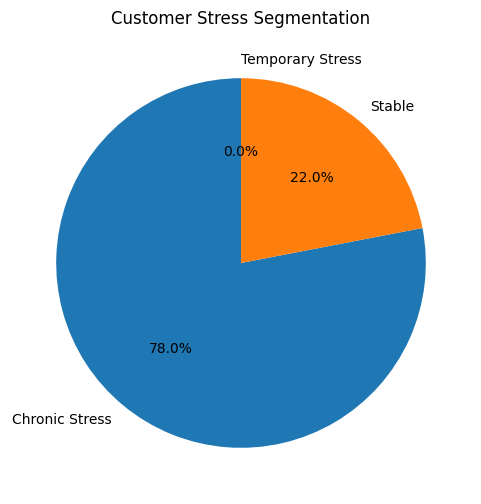

In [26]:
plt.figure(figsize=(6,6))
plt.pie(
    customer_segment_dist['percentage'],
    labels=customer_segment_dist['customer_stress_type'],
    autopct='%1.1f%%',
    startangle=90
)
plt.title('Customer Stress Segmentation')
plt.show()


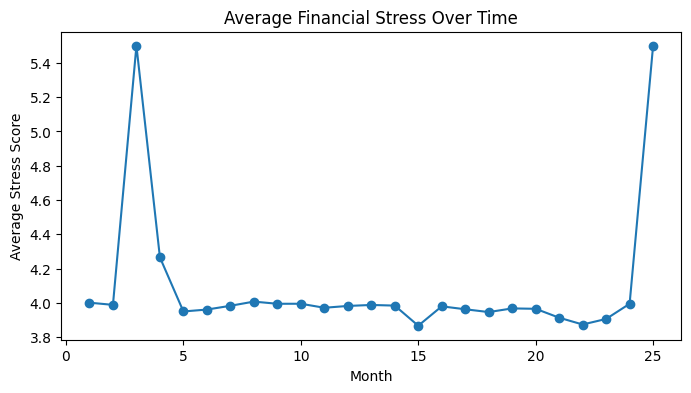

In [27]:
plt.figure(figsize=(8,4))
plt.plot(
    monthly_stress_trend['month'],
    monthly_stress_trend['avg_stress_score'],
    marker='o'
)
plt.title('Average Financial Stress Over Time')
plt.xlabel('Month')
plt.ylabel('Average Stress Score')
plt.show()


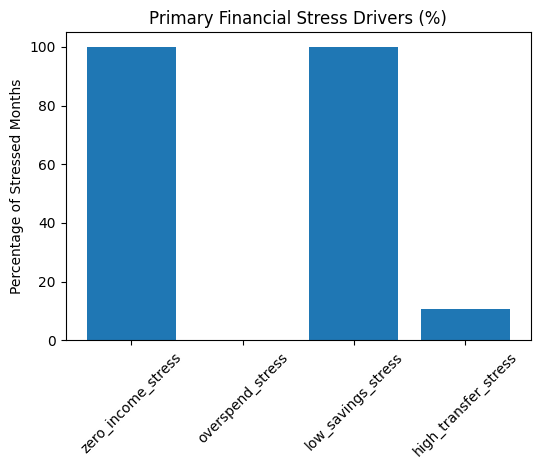

In [28]:
plt.figure(figsize=(6,4))
plt.bar(
    stress_drivers['stress_driver'],
    stress_drivers['percentage']
)
plt.title('Primary Financial Stress Drivers (%)')
plt.ylabel('Percentage of Stressed Months')
plt.xticks(rotation=45)
plt.show()


In [30]:
monthly.to_csv(
    "../data/processed/monthly_metrics.csv",
    index=False
)


In [31]:
stress_dist = monthly['stress_category'].value_counts().reset_index()
stress_dist.columns = ['stress_category', 'count']

stress_dist.to_csv(
    "../data/processed/stress_distribution.csv",
    index=False
)


In [32]:
stress_trend = monthly.groupby('month')['stress_score'].mean().reset_index()

stress_trend.to_csv(
    "../data/processed/stress_trend.csv",
    index=False
)


In [33]:
stress_drivers = pd.DataFrame({
    "driver": ["Zero Income", "Overspending", "Low Savings", "High Transfers"],
    "percentage": [
        (monthly['monthly_income'] == 0).mean() * 100,
        (monthly['expense_income_ratio'] > 1).mean() * 100,
        (monthly['savings_rate'] < 0.1).mean() * 100,
        (monthly['transfer_ratio'] > 0.5).mean() * 100
    ]
})

stress_drivers.to_csv(
    "../data/processed/stress_drivers.csv",
    index=False
)


In [35]:
top_customers = (
    customer_summary
    .sort_values(
        by=['max_stress', 'stressed_months', 'avg_stress'],
        ascending=False
    )
    .head(5000)
)

top_customers.to_csv(
    "../data/processed/top_risk_customers.csv",
    index=False
)
